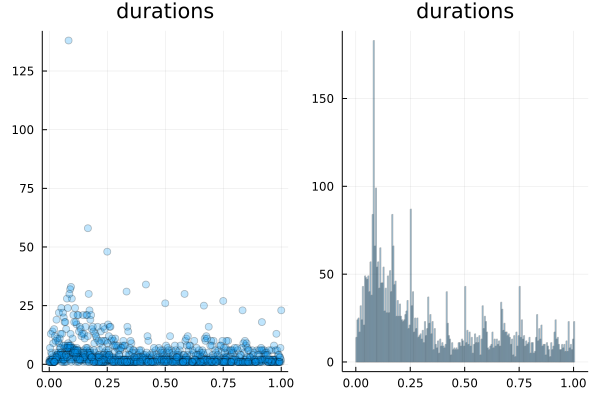

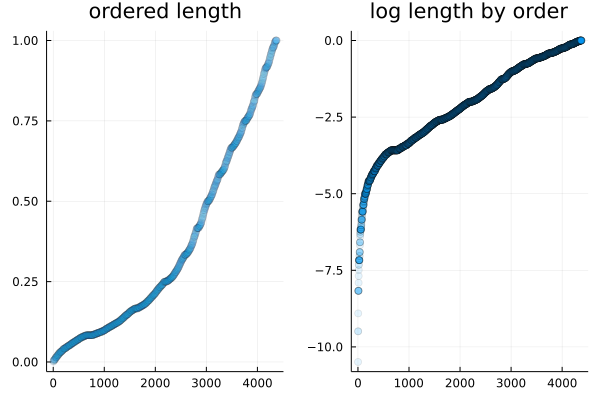

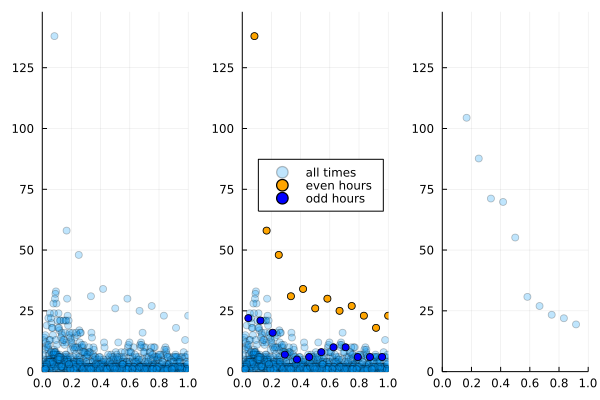

only looking at first:				1.0 days
proportion out by then is about:		69%
in the bar chart each bar covers:		5 minute(s) as set in settings.
...so there are:				288 slices in graphs i.e. total time div by width of bar.
granularity:					288


In [18]:
#s0 libs

using Combinatorics
using DelimitedFiles
using Distributions
using Plots
using Random
using StatsBase
using Test

#=
intent
take an array of durations of seclusion
count the actual distribution of durations
see this curve as being a probability mass function based on two other curves

an exponent which informs reviews, which is when the team feels most sure
    - the ones after teh medical reviews
    -- thought to represent the two hourly review after four hourly medical attendance
    --- with agreement to start two hours of testing which can be succesful
a decay function between those
=#

#s1 config

function get_granularity()
    limit           = get_limit()
    width_of_hists  = get_width_of_hists()
    granularity::Int= (limit*(24*60))/width_of_hists
    println("granularity:\t\t\t\t\t", granularity)
    return granularity
end

function get_limit()
    limit           = 1.0 # days, conventionally a whole number, or round fractions like 0.5
    return limit
end

function get_width_of_hists()
    width_of_hists  = 5
    return width_of_hists
end

function get_width_of_two_hr()
    width_of_two_hr  = 120
    return width_of_two_hr
end


#s2 in out read draw

function draw_cont_scat_freqs(limited)
    count_durs      = collect(countmap(limited))
    durs            = [x[1] for x in count_durs]
    freqs           = [x[2] for x in count_durs]
    cont_scat_freqs = scatter(durs, freqs, alpha=0.25, title="durations", legend=false)
    return cont_scat_freqs
end

function draw_hist_freqs(limited)
    limit           = get_limit()
    minutes         = limit*24*60
    width_of_hists  = get_width_of_hists()
    n_hists::Int    = minutes/width_of_hists
    println("in the bar chart each bar covers:\t\t", width_of_hists, " minute(s) as set in settings.")
    println("...so there are:\t\t\t\t", n_hists, " slices in graphs i.e. total time div by width of bar.")
    hist_freqs      = histogram(limited, bins=n_hists, alpha=0.25, legend=false, title="durations")
    return hist_freqs
end

function draw_scat_abs(limited)
    orders          = 1:length(limited)
    scat_abs        = scatter(orders, limited, alpha=0.02, title="ordered length", legend=false)
    return scat_abs
end

function draw_scat_logs(limited)
    orders          = 1:length(limited)
    log_abs         = [log2(d) for d in limited]
    scat_logs       = scatter(orders, log_abs, alpha=0.1, title="log length by order", legend=false)
    return scat_logs
end

function read_durations()
    output_matrix = readdlm("durations.txt", ' ', Float64, '\n')
    durations     = output_matrix[1,:]
    return durations
end


#s3 model

function count_limited()
    durations           = read_durations()
    total               = length(durations)
    limit               = get_limit()
    limited             = [d for d in durations if d<=limit]
    cumulative_fraction = length(limited)/total
    return limited
end

function draw_interp_exp(θ, this_many_reviews)
    
    #println("this many even reviews:\t", this_many_even_reviews)
    Random.seed!(4579) # Setting the seed if you want similar rands each time - not my cup of tea    
    
    granularity         = get_granularity()
    limited             = count_limited()
    count_durs          = collect(countmap(limited))
    freqs               = [x[2] for x in count_durs]
    max_y               = maximum(freqs)
    
    limit               = get_limit()
    interpolated_exp    = Exponential(θ)
    noisy_exp           = rand(interpolated_exp, this_many_reviews)
    max_noisy           = maximum(noisy_exp)
    rand_exponential_ys = [y[2] for y in enumerate(reverse(sort(noisy_exp))) if y[1]<this_many_reviews]
    
    xs                  = []
    for this_review in 1:this_many_reviews-1
        push!(xs,  this_review/12)
    end
    
    scatterg            = scatter(xs, rand_exponential_ys, 
                            xlims=(0,limit), 
                            ylims=(0,max_y+10), 
                            legend=false, alpha=0.25)
    return scatterg
end
    
function get_xs()
    limit               = get_limit()
    minutes             = limit*24*60
    width_of_hists      = get_width_of_hists()
    n_hists::Int        = minutes/width_of_hists
    xs                  = [float(x) for x in collect(1:n_hists)]
    return xs
end

function get_even_odd_review_durations()
    limit                          = get_limit()
    minutes                        = limit*24*60
    
    width_of_two_hr                = get_width_of_two_hr()
    n_two_hr_blocks::Int           = minutes/width_of_two_hr
    review_range                   = collect(1:n_two_hr_blocks)
    
    even_hours                     = [r*2 for r in review_range]
    odd_hours                      = [h-1 for h in even_hours]
    
    even_hours_in_days             = [d/24 for d in even_hours]
    odd_hours_in_days              = [d/24 for d in odd_hours]
    
    even_odd_review_durations      = even_hours_in_days, odd_hours_in_days 
    return even_odd_review_durations
end

function harry_maths()
    limited                        = count_limited()
    count_durs                     = collect(countmap(limited))
    durs                           = [x[1] for x in count_durs]
    freqs                          = [x[2] for x in count_durs]
    all_scatter                    = scatter(durs, freqs, alpha=0.25, 
                                     xlims=(0,maximum(durs)), 
                                     ylims=(0,maximum(freqs)+10), label="all times", legend=false)
    
    even_odd_review_durations      = get_even_odd_review_durations()
    even_reviews_durations         = [round(d; digits = 4) for d in even_odd_review_durations[1]]
    odd_reviews_durations          = [round(d; digits = 4) for d in even_odd_review_durations[2]]
    
    even_durs       = [x[1] for x in count_durs if in(round(x[1], digits = 4), even_reviews_durations)]
    even_freqs      = [x[2] for x in count_durs if in(round(x[1], digits = 4), even_reviews_durations)]
    odd_durs        = [x[1] for x in count_durs if in(round(x[1], digits = 4), odd_reviews_durations)]
    odd_freqs       = [x[2] for x in count_durs if in(round(x[1], digits = 4), odd_reviews_durations)]
    
    combo            = scatter(durs, freqs, alpha=0.25, xlims=(0,maximum(durs)), ylims=(0,maximum(freqs)+10), label="all times", legend=:right)
    combo            = scatter!(even_durs, even_freqs, alpha=1.0, color="orange", label="even hours")
    combo            = scatter!(odd_durs, odd_freqs,   alpha=1.0, color="blue", label="odd hours")

    this_many_reviews= length(even_freqs)
    
    θ               = params(fit_mle(Exponential, even_freqs))[1]
    interp_exp      = draw_interp_exp(θ, this_many_reviews)
    harry_graph     = plot(all_scatter, combo, interp_exp, layout=(1,3))
        
    return harry_graph
end

function initial_analysis()
    limited         = count_limited()
    scat_logs       = draw_scat_logs(limited)
    scat_abs        = draw_scat_abs(limited)
    initial         = plot(scat_abs, scat_logs, layout=(1,2), legend=false)
    return initial
end

function my_poisson(k, labda)    
    probability = (labda^k)*(ℯ^(-labda))/factorial(big(k))
    return probability
end

function no_real_analysis()
    limited         = count_limited()
    cont_scat_freqs = draw_cont_scat_freqs(limited)
    hist_freqs      = draw_hist_freqs(limited)
    unanalysed      = plot(cont_scat_freqs, hist_freqs, layout=(1,2), legend=false)
    return unanalysed
end

function dist_poisson(xs, labda)
    xs              = [trunc(Int64,x) for x in xs]
    ys              = [my_poisson(x, labda) for x in xs]
    return ys
end

function tell_config()
    limit               = get_limit()
    durations           = read_durations()
    total               = length(durations)
    limited             = [d for d in durations if d<=limit]
    cumulative_fraction = length(limited)/total
    println("only looking at first:\t\t\t\t",limit," days")
    println("proportion out by then is about:\t\t", trunc(Int64,cumulative_fraction*100),"%")
end

function exp_pdf(x,β)
    y = (1/β)*ℯ^(-x/β)
    return y
end

function harry_main()
    tell_config()
    unanalysed                   = no_real_analysis()
    initial                      = initial_analysis()
    harry_graph                  = harry_maths()
    return unanalysed, initial, harry_graph
end

unanalysed, initial, harry_graph = harry_main();
    
display(unanalysed); display(initial); display(harry_graph)

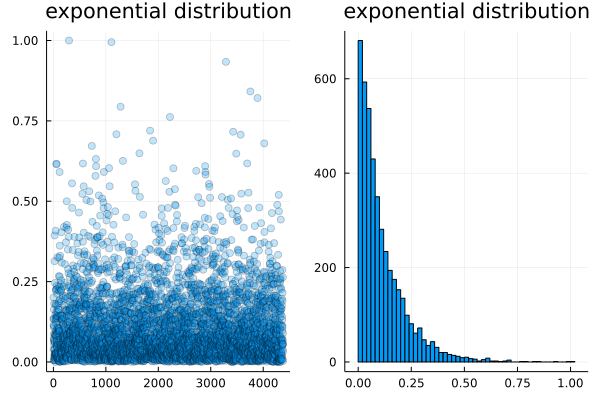

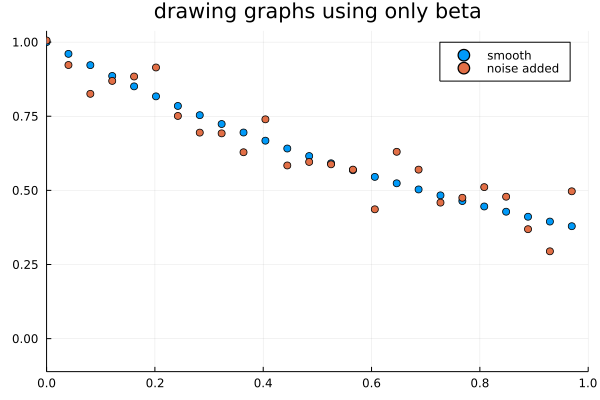


any exponential graph has a measure called beta
we can measure it and use it to draw a new graph

passed get_even_odd_review_durations
passed my_poisson
passed get_xs
passed all tests


In [19]:
# some spare demos


function demo_normal()
    durations           = read_durations()
    total               = length(durations)
    limit               = get_limit()
    limited             = [d for d in durations if d<=limit]
    cumulative_count    = length(limited)
    cumulative_fraction = cumulative_count/total
    
    d             = Normal()
    Random.seed!(123) # Setting the seed
    raw_x         = rand(d, cumulative_count)
    max_raw_x     = maximum(raw_x)
    limit         = get_limit()
    x             = [(0.5*max_raw_x)+limit*(rx/max_raw_x) for rx in raw_x]
    scatterg      = scatter(x,legend=false,alpha=0.25)
    histog        = histogram(x,legend=false)
    graphs        = plot(scatterg, histog, layout=(1,2))
    return graphs
end

#normal_graphs = demo_normal()

function demo_poisson()
    durations           = read_durations()
    total               = length(durations)
    limit               = get_limit()
    limited             = [d for d in durations if d<=limit]
    cumulative_count    = length(limited)
    cumulative_fraction = cumulative_count/total
    
    d             = Poisson(4)
    Random.seed!(123) # Setting the seed
    raw_x         = rand(d, cumulative_count)
    max_raw_x     = maximum(raw_x)
    limit         = get_limit()
    x             = [limit*(rx/max_raw_x) for rx in raw_x]
    scatterg      = scatter(x,alpha=0.25,legend=false)
    histog        = histogram(x,legend=false)
    graphs        = plot(scatterg, histog, layout=(1,2))
    return graphs
end

#poisson_graphs = demo_poisson()

function demo_uniform()
    d             = Uniform()
    Random.seed!(123) # Setting the seed
    raw_x         = rand(d, 100)
    max_raw_x     = maximum(raw_x)
    limit         = get_limit()
    x             = [limit*(rx/max_raw_x) for rx in raw_x]
    scatterg      = scatter(x,alpha=0.25,legend=false)
    histog        = histogram(x,legend=false)
    graphs        = plot(scatterg, histog, layout=(1,2))
    return graphs
end

#graphs = demo_uniform()

# some live demos

function demo_exponential_histogram()
    
    durations           = read_durations()
    total               = length(durations)
    limit               = get_limit()
    limited             = [d for d in durations if d<=limit]
    cumulative_count    = length(limited)
    
    
    d             = Exponential()
    Random.seed!(123) # Setting the seed
    raw_ys        = rand(d, cumulative_count)
    max_raw_y     = maximum(raw_ys)
    limit         = get_limit()
    ys            = [limit*(ry/max_raw_y) for ry in raw_ys]
    scatterg      = scatter(ys,alpha=0.25,legend=false)
    histog        = histogram(ys,legend=false)
    graphs        = plot(scatterg, histog, layout=(1,2), title="exponential distribution")
    println("\nany exponential graph has a measure called beta")
    println("we can measure it and use it to draw a new graph\n")
    return graphs
end
exponential_graphs = demo_exponential_histogram()

function demo_exp_pdf()
    limit       = get_limit()
    β           = 1
    xs          = range(0,4,100)
    ys          = map(x -> exp_pdf(x,β),xs)
    exp_pdfg    = scatter(xs, ys, xlims=(0,limit), label="smooth", title="drawing graphs using only beta")
    noisy_pdf   = scatter!(xs, [(y+rand(1)[1]*0.25-0.125) for y in ys], label="noise added")
    return exp_pdfg
end
exponential_probability_distribution_function = demo_exp_pdf()

display(exponential_graphs); display(exponential_probability_distribution_function)



#s7 tests

function test_get_xs()
    xs              = get_xs()
    limit           = get_limit()
    minutes         = limit*24*60
    width_of_hists  = get_width_of_hists()
    n_hists::Int    = minutes/width_of_hists
    @test length(xs) == n_hists
    println("passed get_xs")
end

function test_get_even_odd_review_durations()
    even_odd_review_durations  = get_even_odd_review_durations()
    @test typeof(even_odd_review_durations) == Tuple{Vector{Float64}, Vector{Float64}}
    even_review_durations = even_odd_review_durations[1]
    odd_review_durations  = even_odd_review_durations[2]
    @test mean(.>(even_review_durations, odd_review_durations))==1.0
    println("passed get_even_odd_review_durations")
end

function test_my_poisson()
    xs            = collect(1:20) 
    labda         = 4
    my_scores     = dist_poisson(xs, labda)
    their_pdf     = Poisson(labda)
    their_scores  = [pdf(their_pdf,x) for x in xs]
    @test isapprox(my_scores,their_scores; atol = 1.0e-12)
    println("passed my_poisson")
end

function harry_tests()
    test_get_even_odd_review_durations()
    test_my_poisson()
    test_get_xs()
    println("passed all tests")
end

harry_tests()

#=
    xs                  = get_xs()
    even_labda          = get_even_labda()
    even_scale          = 1000
    unscaled_even_ys    = dist_poisson(xs, even_labda)
    even_ys             = .*(unscaled_even_ys, even_scale)
    
    odd_labda           = get_odd_labda()
    odd_scale           = 1000
    unscaled_odd_ys     = dist_poisson(xs, odd_labda)
    odd_ys              = .*(unscaled_odd_ys, odd_scale)
    
    max_x               = maximum(xs)
    c                   = 50
    straight_line       = [c-(c*(x/max_x)) for x in xs]
    println(straight_line)
    
    ys                  = .+(even_ys, odd_ys, straight_line) 
    summed_poisson      = scatter(xs,ys)
    =#

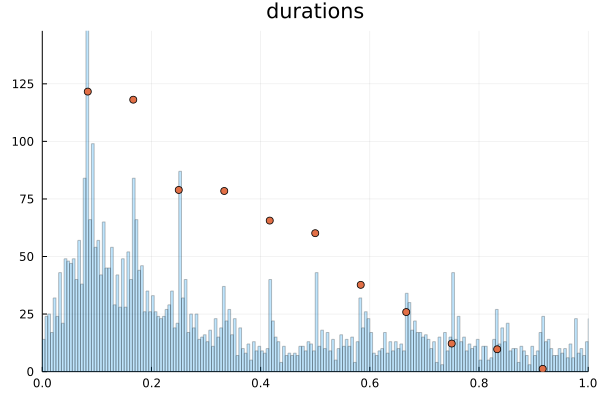

granularity:					288
in the bar chart each bar covers:		5 minute(s) as set in settings.
...so there are:				288 slices in graphs i.e. total time div by width of bar.


In [25]:
function trace_whole_function()
    limited                        = count_limited()
    count_durs                     = collect(countmap(limited))
    durs                           = [x[1] for x in count_durs]
    freqs                          = [x[2] for x in count_durs]
        
    even_odd_review_durations      = get_even_odd_review_durations()
    even_reviews_durations         = [round(d; digits = 4) for d in even_odd_review_durations[1]]
    odd_reviews_durations          = [round(d; digits = 4) for d in even_odd_review_durations[2]]
    
    even_durs           = [x[1] for x in count_durs if in(round(x[1], digits = 4), even_reviews_durations)]
    even_freqs          = [x[2] for x in count_durs if in(round(x[1], digits = 4), even_reviews_durations)]
    odd_durs            = [x[1] for x in count_durs if in(round(x[1], digits = 4), odd_reviews_durations)]
    odd_freqs           = [x[2] for x in count_durs if in(round(x[1], digits = 4), odd_reviews_durations)]
    
    this_many_reviews   = length(even_freqs)
    
    θ                   = params(fit_mle(Exponential, even_freqs))[1]
    
    granularity         = get_granularity()
    limited             = count_limited()
    count_durs          = collect(countmap(limited))
    freqs               = [x[2] for x in count_durs]
    max_y               = maximum(freqs)
    
    limit               = get_limit()
    interpolated_exp    = Exponential(θ)
    noisy_exp           = rand(interpolated_exp, this_many_reviews)
    max_noisy           = maximum(noisy_exp)
    rand_exponential_ys = [y[2] for y in enumerate(reverse(sort(noisy_exp))) if y[1]<this_many_reviews]
    
    xs                  = []
    for this_review in 1:this_many_reviews-1
        push!(xs,  this_review/12)
    end
    
    hist_freqs          = draw_hist_freqs(limited)
    overlaid            = scatter!(xs, rand_exponential_ys, 
                            xlims=(0,limit), 
                            ylims=(0,max_y+10), 
                            legend=false, alpha=1.0)
    
    underlaid           = 
    
    return overlaid
end

overlaid = trace_whole_function()

display(overlaid)
